# The canonical HANK model with sticky prices

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Step 1: Steady state](#toc2_)    
- 3. [Step 2: Compute Jacobians](#toc3_)    
- 4. [Step 3a: Find non-linear transition path](#toc4_)    
  - 4.1. [Find transition path](#toc4_1_)    
  - 4.2. [Plot transitions](#toc4_2_)    
- 5. [Step 3b: Find linearized IRFs](#toc5_)    
- 6. [Transfers](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANKModel import HANKModelClass
from steady_state import obj_ss

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANKModelClass(name='baseline')

In [3]:
model.info()

settings:
 par.py_hh = True
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [w,ra,L,tau,chi]
 inputs_hh_z: []
 outputs_hh: [a,c]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [G,chi,Gamma]
 unknowns: [pi_w,L]
 targets: [NKWC_res,clearing_A]

blocks (inputs -> outputs):
 production: [Gamma,pi_w,L] -> [path,w,pi,Y]
 central_bank: [path,pi] -> [i,r]
 mutual_fund: [path,r] -> [q,ra]
 government: [path,G,chi,q,Y] -> [B,tau]
 hh: [L,chi,ra,tau,w] -> [A_hh,C_hh]
 NKWC: [path,pi_w,L,tau,w,C_hh] -> [NKWC_res]
 market_clearing: [path,G,q,B,Y,C_hh,A_hh] -> [A,clearing_A,clearing_Y]


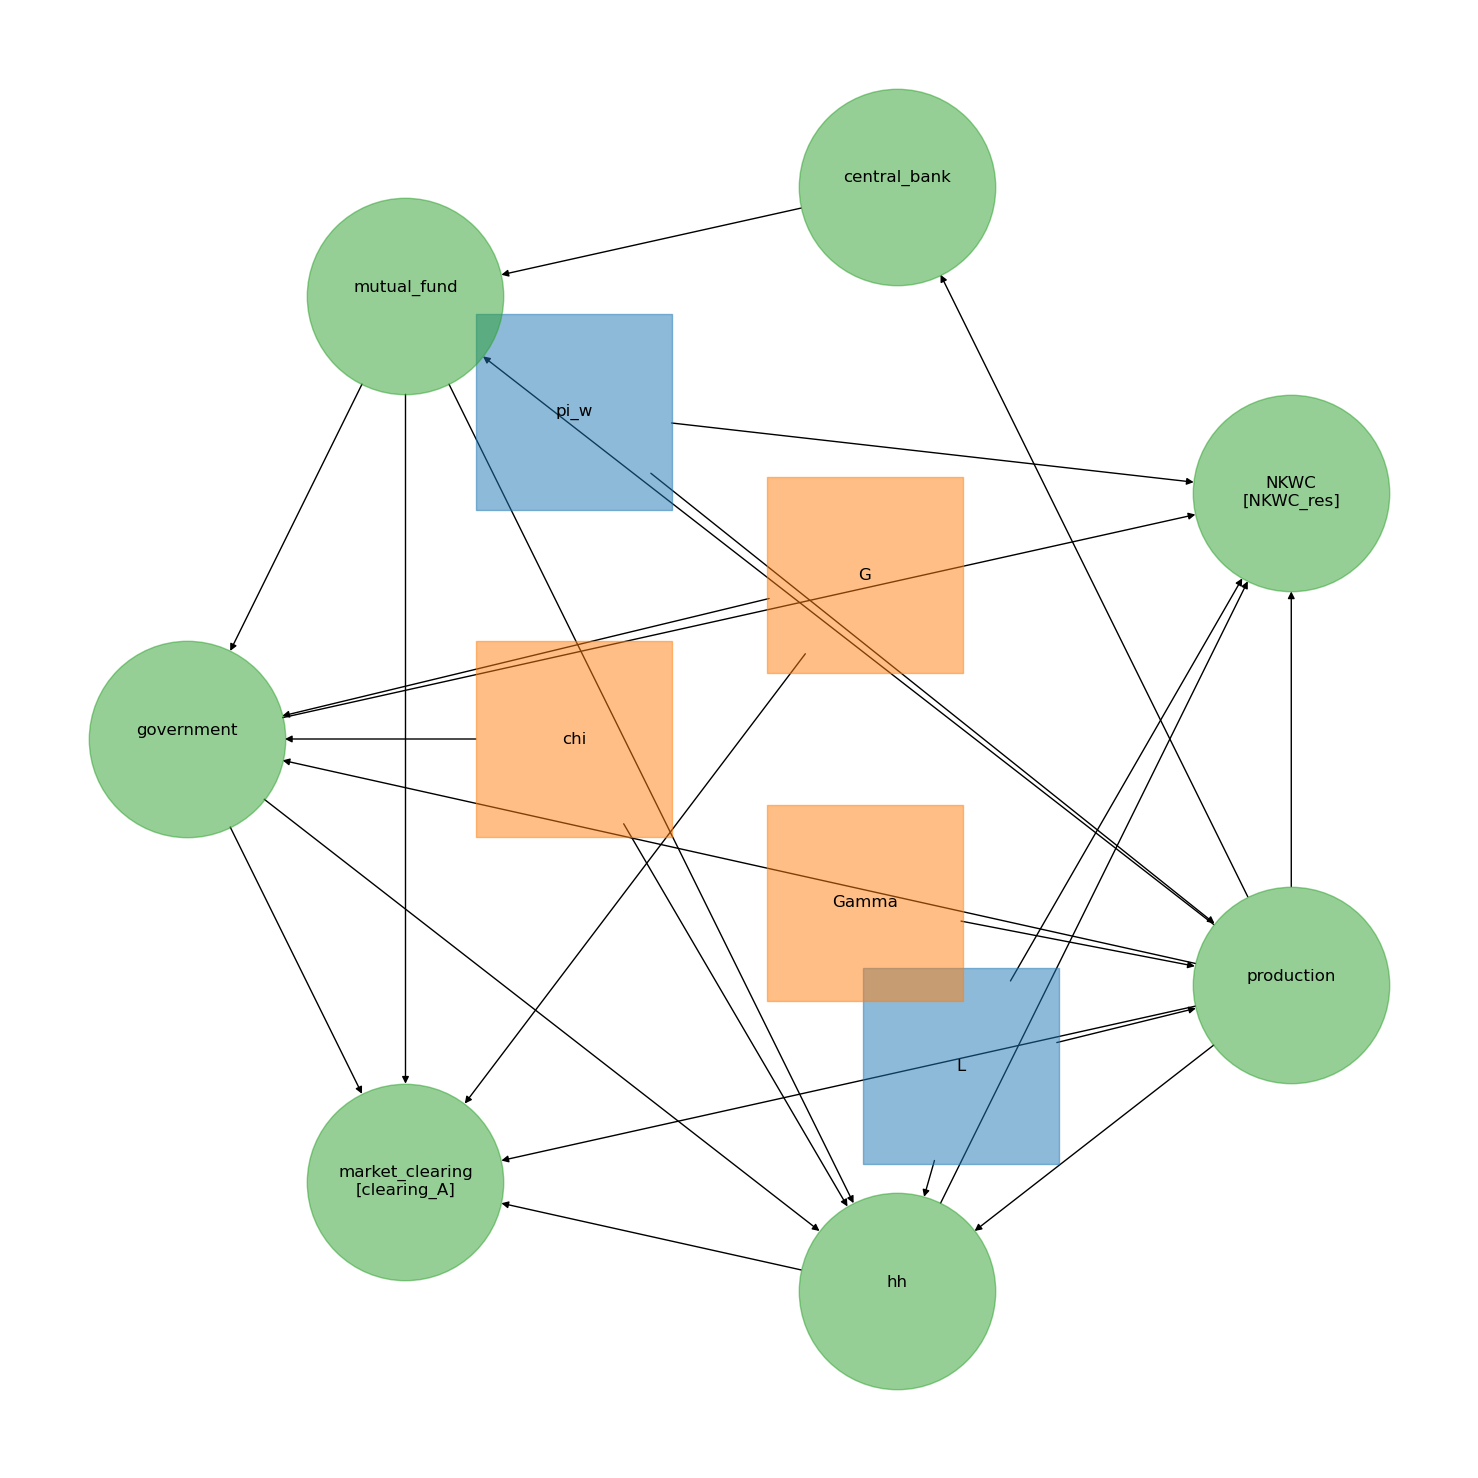

In [4]:
model.draw_DAG(figsize=(15,15),order=['shocks','unknowns','blocks'])

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

## 2. <a id='toc2_'></a>[Step 1: Steady state](#toc0_)

In [6]:
beta_vec = np.linspace(0.85**(1/4),1/(1+par.r_target_ss)-1e-4,5)
clearing_A_vec = np.zeros(beta_vec.size)
for i,beta in enumerate(beta_vec):
    clearing_A_vec[i] = obj_ss(beta,model,do_print=False)
    print(f'{beta = :.2f} = {clearing_A_vec[i] = :12.8f}')

beta = 0.96 = clearing_A_vec[i] =   0.78571842
beta = 0.97 = clearing_A_vec[i] =   0.52651384
beta = 0.98 = clearing_A_vec[i] =  -0.09615917
beta = 0.99 = clearing_A_vec[i] =  -2.00527786
beta = 0.99 = clearing_A_vec[i] = -30.46729852


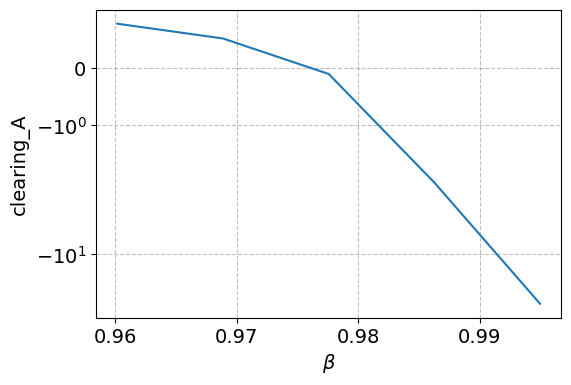

In [7]:
fig = plt.figure(figsize=(6,4),dpi=100)
ax = fig.add_subplot(1,1,1)
ax.plot(beta_vec,clearing_A_vec)
ax.set_yscale('symlog')
ax.set_xlabel('$\\beta$')
ax.set_ylabel('clearing_A');

In [8]:
model.find_ss(do_print=True)

steady state found in 6.0 secs
 r    =   0.0050
 q    =   4.8789
 qB   =   1.0000
Discrepancy in A =   0.00000000
Discrepancy in Y =   0.00000000


In [9]:
MPC = np.sum(ss.D[:,:,:-1]*(ss.c[:,:,1:]-ss.c[:,:,:-1])/((1+ss.ra)*(par.a_grid[1:]-par.a_grid[:-1])))
print(f'{MPC:.2f}')

0.29


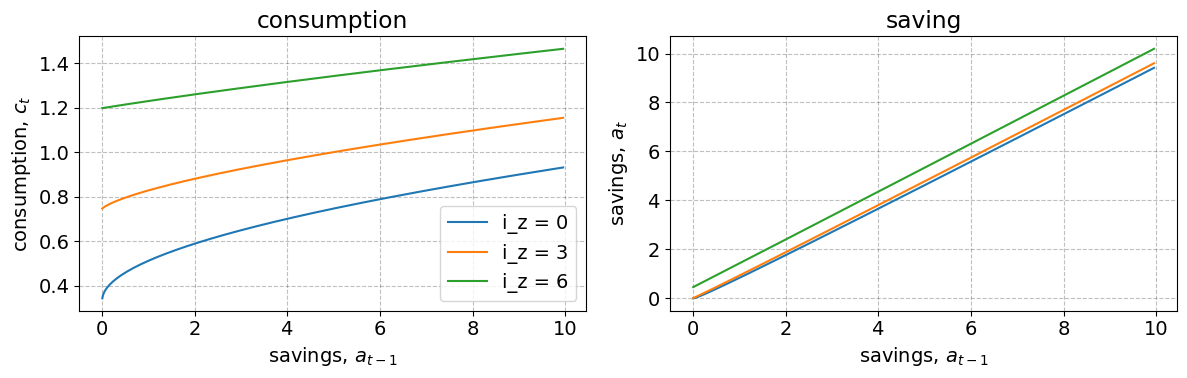

In [10]:
fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 10

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[0,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[0,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

fig.tight_layout()

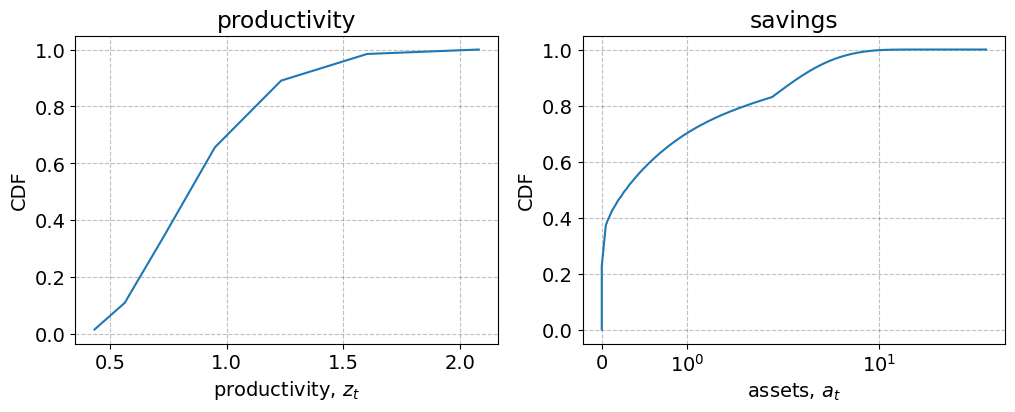

In [11]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D[0],axis=1))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D[0],axis=0)),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')

## 3. <a id='toc3_'></a>[Step 2: Compute Jacobians](#toc0_)

**Household transition path:**

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 0.5 secs
household problem simulated along transition in 1.1 secs



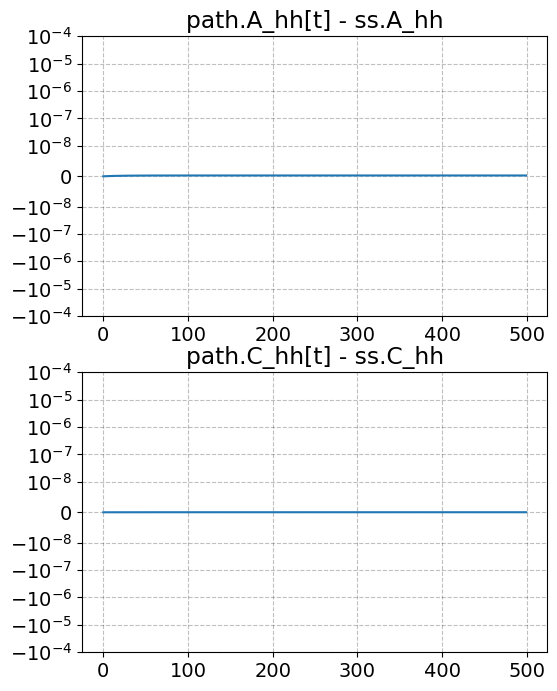

In [12]:
model.test_hh_path()

**Full transition path:**

In [13]:
model.test_path()

shocks: G chi Gamma 
unknowns: pi_w L 

blocks.production
 path                 nan
 w                0.0e+00
 pi               0.0e+00
 Y                0.0e+00
blocks.central_bank
 i                0.0e+00
 r                0.0e+00
blocks.mutual_fund
 q                0.0e+00
 ra               0.0e+00
blocks.government
 B                0.0e+00
 tau              0.0e+00
hh
 A_hh             2.7e-10
 C_hh             1.5e-11
blocks.NKWC
 NKWC_res         3.8e-12 [target]
blocks.market_clearing
 A                0.0e+00
 clearing_A       2.5e-10 [target]
 clearing_Y       1.5e-11


**Jacobians:**

In [14]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for L               in 0.4 secs
curly_Y and curly_D calculated for chi             in 0.4 secs
curly_Y and curly_D calculated for ra              in 0.4 secs
curly_Y and curly_D calculated for tau             in 0.4 secs
curly_Y and curly_D calculated for w               in 0.5 secs
curly_E calculated in 1.6 secs
builiding blocks combined in 0.2 secs
household Jacobian computed in 4.1 secs

full Jacobians:
full Jacobian to unknowns computed in 0.5 secs [in evaluate_blocks(): 0.3 secs]
full Jacobian to shocks computed in 0.7 secs [in evaluate_blocks(): 0.4 secs]


## 4. <a id='toc4_'></a>[Step 3a: Find non-linear transition path](#toc0_)

### 4.1. <a id='toc4_1_'></a>[Find transition path](#toc0_)

In [15]:
model.par.jump_G = 0.01*ss.G
model.par.rho_G = 0.80

In [16]:
model.find_transition_path(shocks=['G'],do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 5.93e-03
   6.57e-05 in NKWC_res
   5.93e-03 in clearing_A
 it =   1 -> max. abs. error = 7.50e-06
   5.04e-07 in NKWC_res
   7.50e-06 in clearing_A
 it =   2 -> max. abs. error = 1.37e-08
   8.45e-10 in NKWC_res
   1.37e-08 in clearing_A
 it =   3 -> max. abs. error = 7.20e-12
   3.04e-13 in NKWC_res
   7.20e-12 in clearing_A

transition path found in 2.4 secs


### 4.2. <a id='toc4_2_'></a>[Plot transitions](#toc0_)

### shocks ###


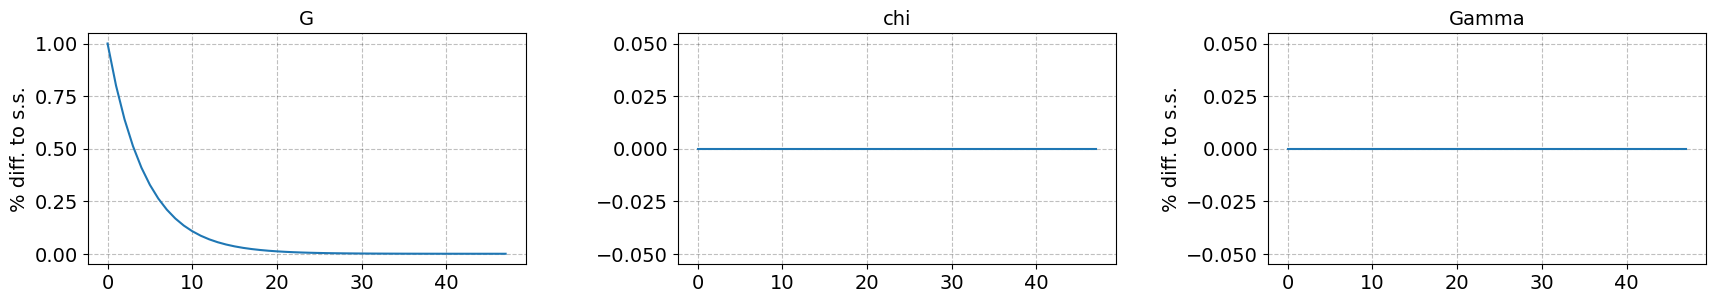


### varnames ###


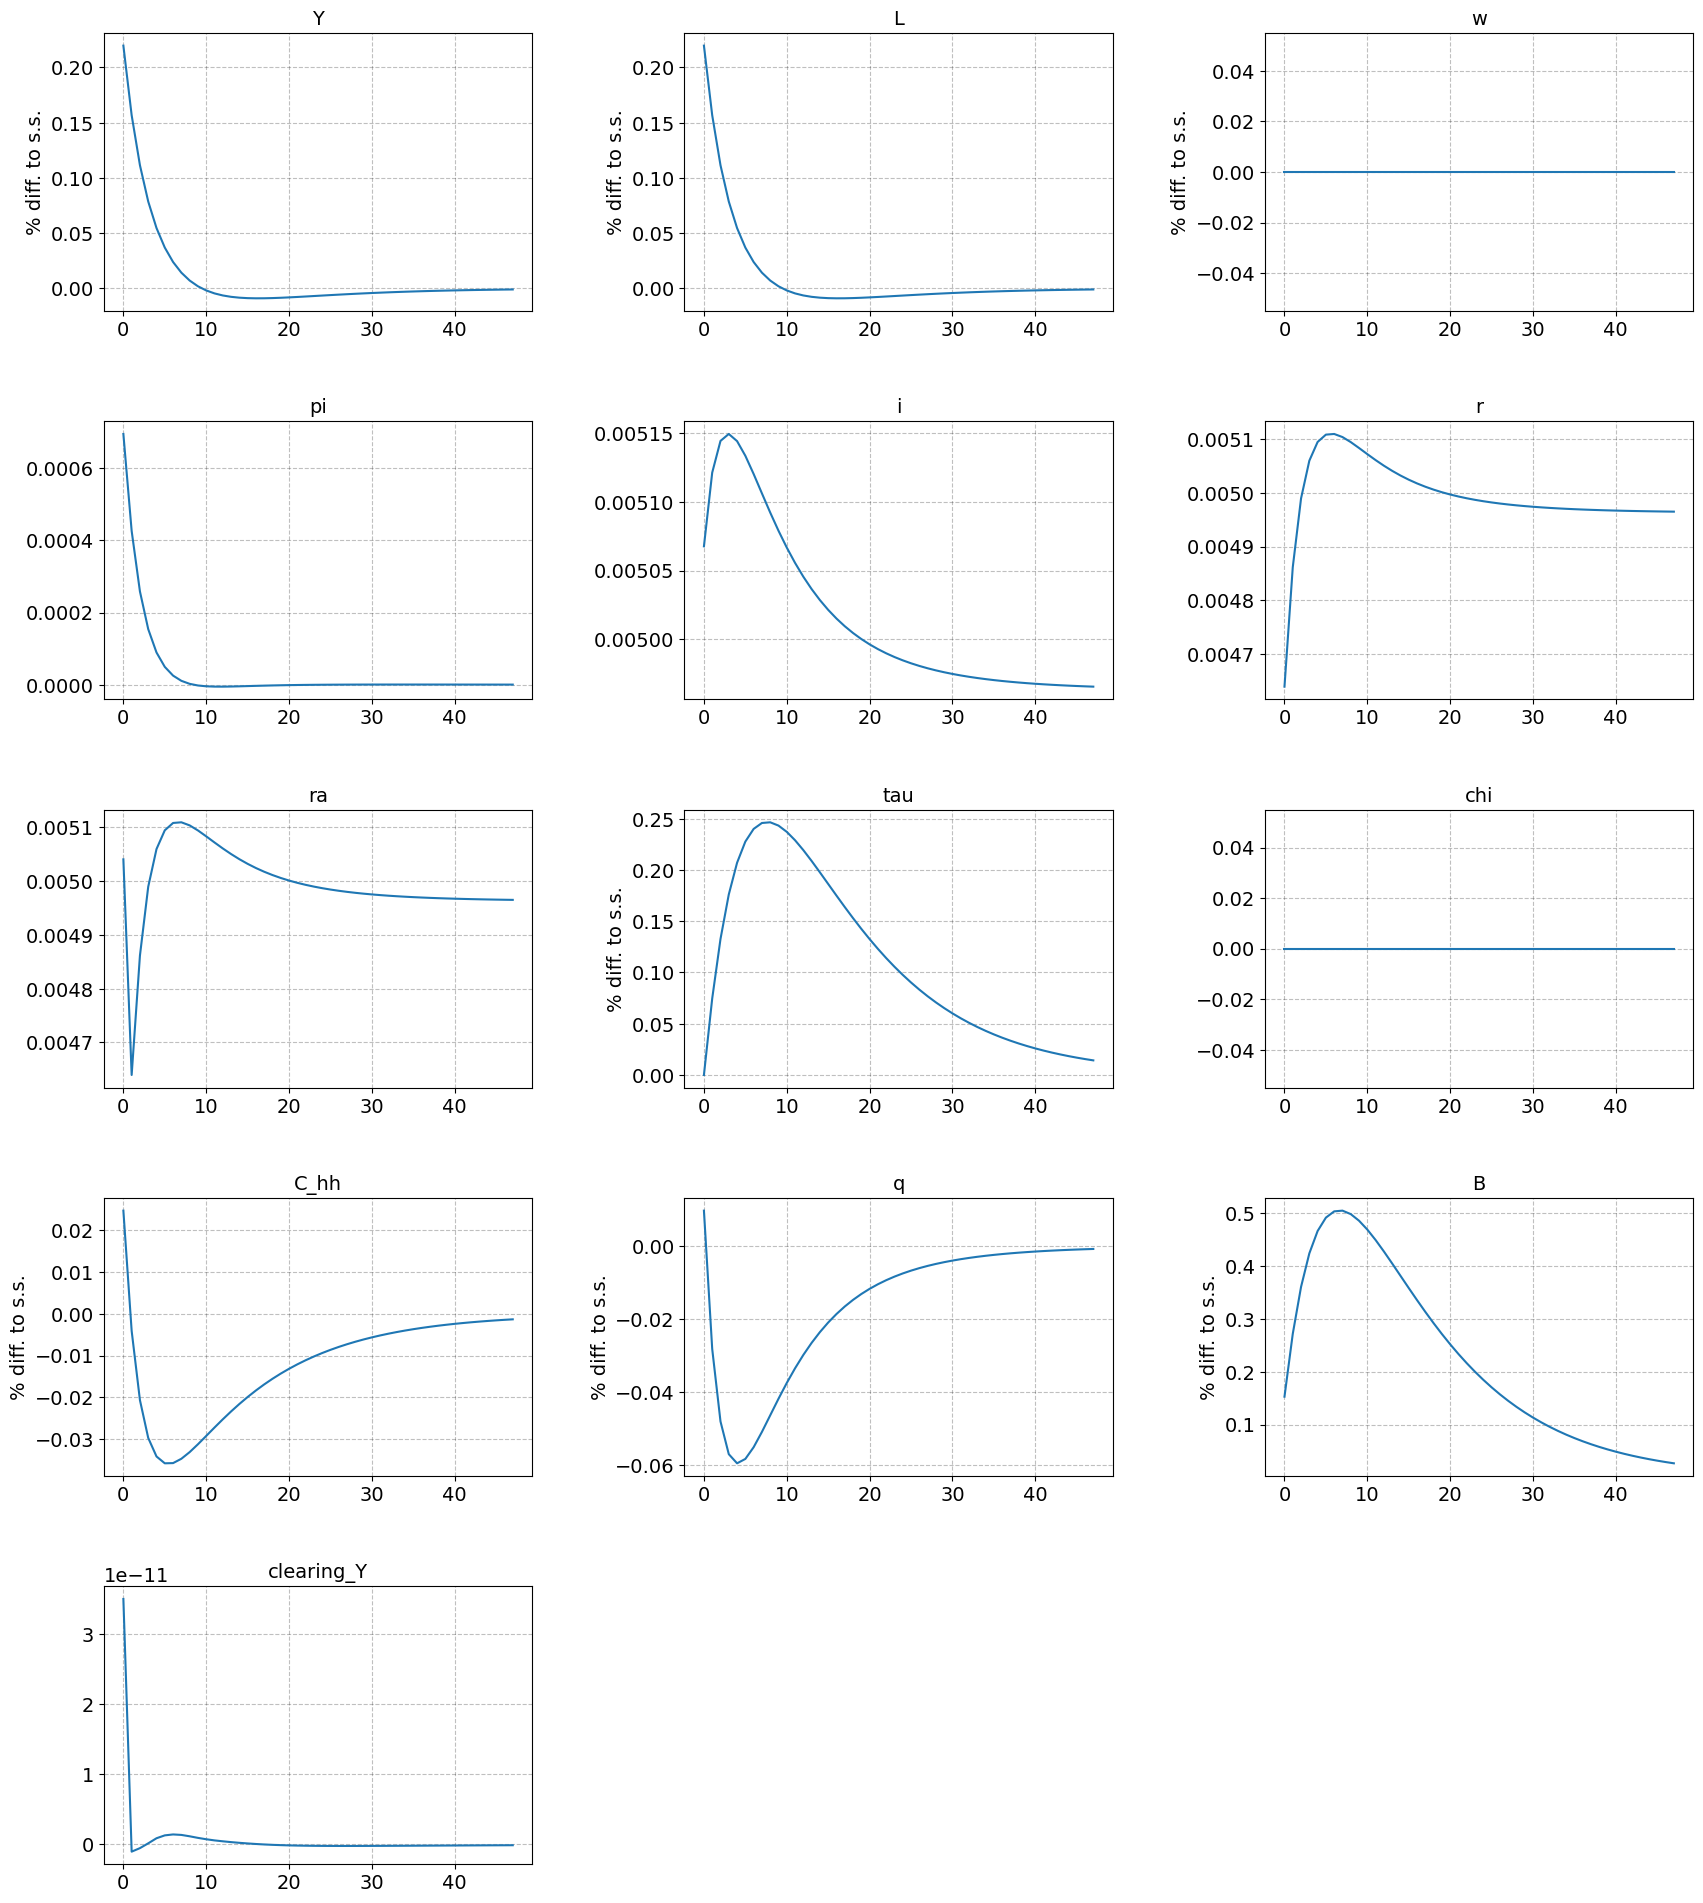


### tagets ###


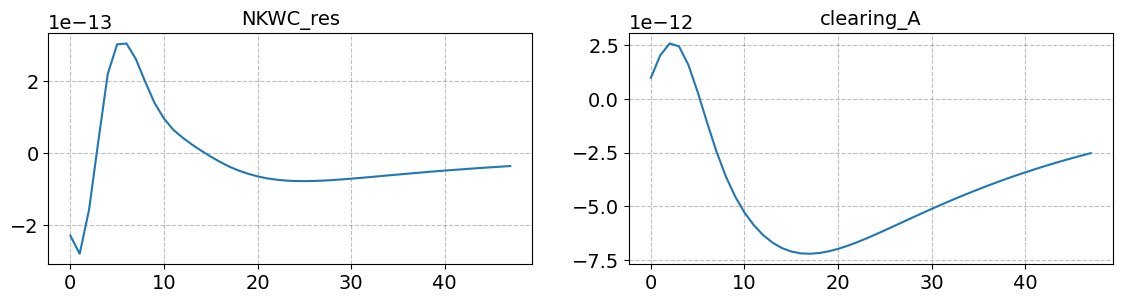

In [17]:
paths = ['Y','L','w','pi','i','r','ra','tau','chi','C_hh','q','B','clearing_Y']
lvl_value=['ra','i','r','pi','chi','clearing_A','clearing_Y']
model.show_IRFs(paths,lvl_value=lvl_value,T_max=48,ncols=3)

['w']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs

['ra']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs

['L']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs

['tau']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs

['chi']
household problem solved along transition path in 0.4 secs
household problem simulated along transition in 0.1 secs



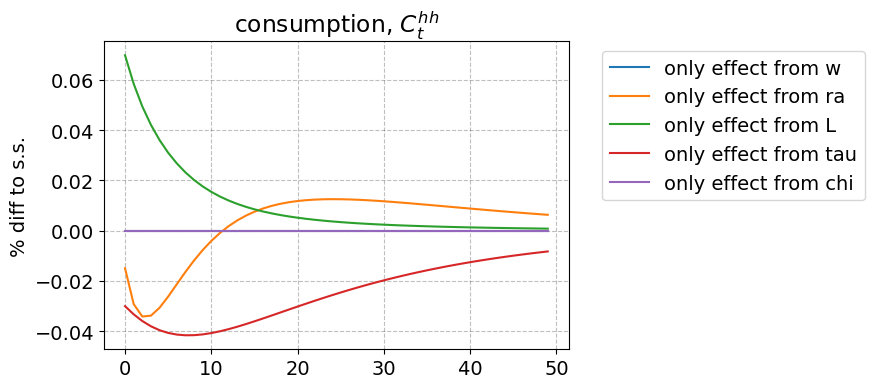

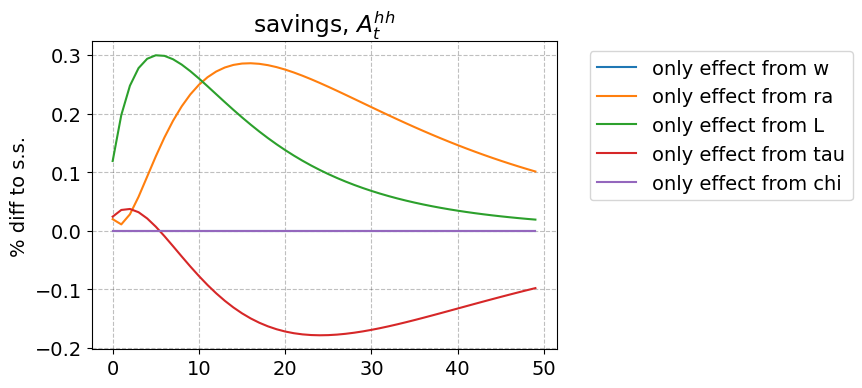

In [18]:
T_max = 50

fig_C = plt.figure(figsize=(6,4),dpi=100)
ax_C = fig_C.add_subplot(1,1,1)
ax_C.set_title('consumption, $C_t^{hh}$')
               
fig_A = plt.figure(figsize=(6,4),dpi=100)
ax_A = fig_A.add_subplot(1,1,1)
ax_A.set_title('savings, $A_t^{hh}$')
               
i_color = 0
for use_inputs in [[x] for x in model.inputs_hh]:
    
    # a. compute
    print(use_inputs)
    path_alt = model.decompose_hh_path(do_print=True,use_inputs=use_inputs)
    print('')
    
    # b. plot
    if use_inputs is None:
        label = 'no inputs'
        ls = '--'
        color = 'black'
    elif use_inputs == 'all':
        label = 'all inputs'
        ls = '-'
        color = 'black'
    else:
        label = f'only effect from {use_inputs[0]}'
        ls = '-'
        color = colors[i_color]
        i_color += 1
        
    ax_C.plot((path_alt.C_hh[:50]/ss.C_hh-1)*100,ls=ls,color=color,label=label);
    ax_A.plot((path_alt.A_hh[:50]/ss.A_hh-1)*100,ls=ls,color=color,label=label);    

for ax in [ax_C,ax_A]:
    ax.set_ylabel('% diff to s.s.')
    lgd = ax.legend(frameon=True,ncol=1,bbox_to_anchor=(1.05,1), loc='upper left',)

plt.show()

## 5. <a id='toc5_'></a>[Step 3b: Find linearized IRFs](#toc0_)

In [19]:
model.find_IRFs(shocks=['G'],do_print=True)

linear transition path found in 0.1 secs [finding solution matrix: 0.1 secs]


### shocks ###


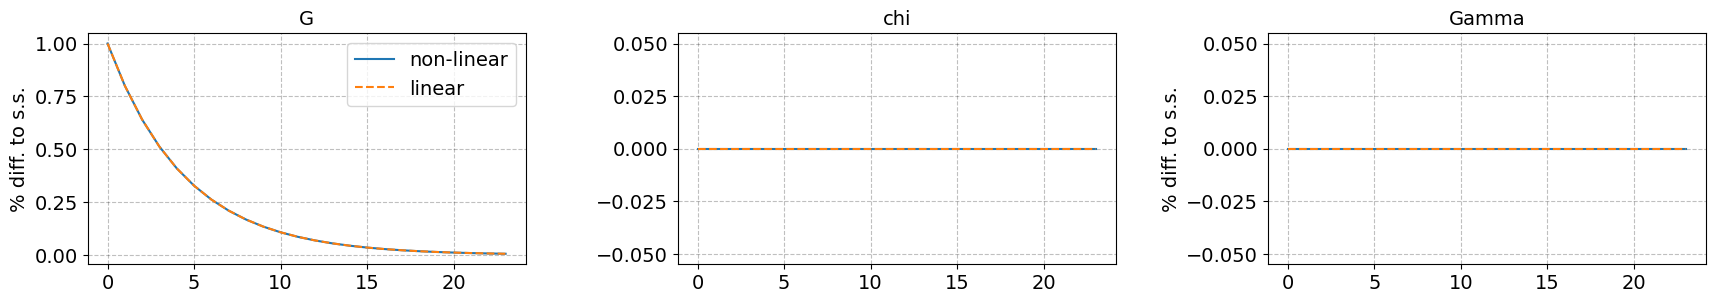


### varnames ###


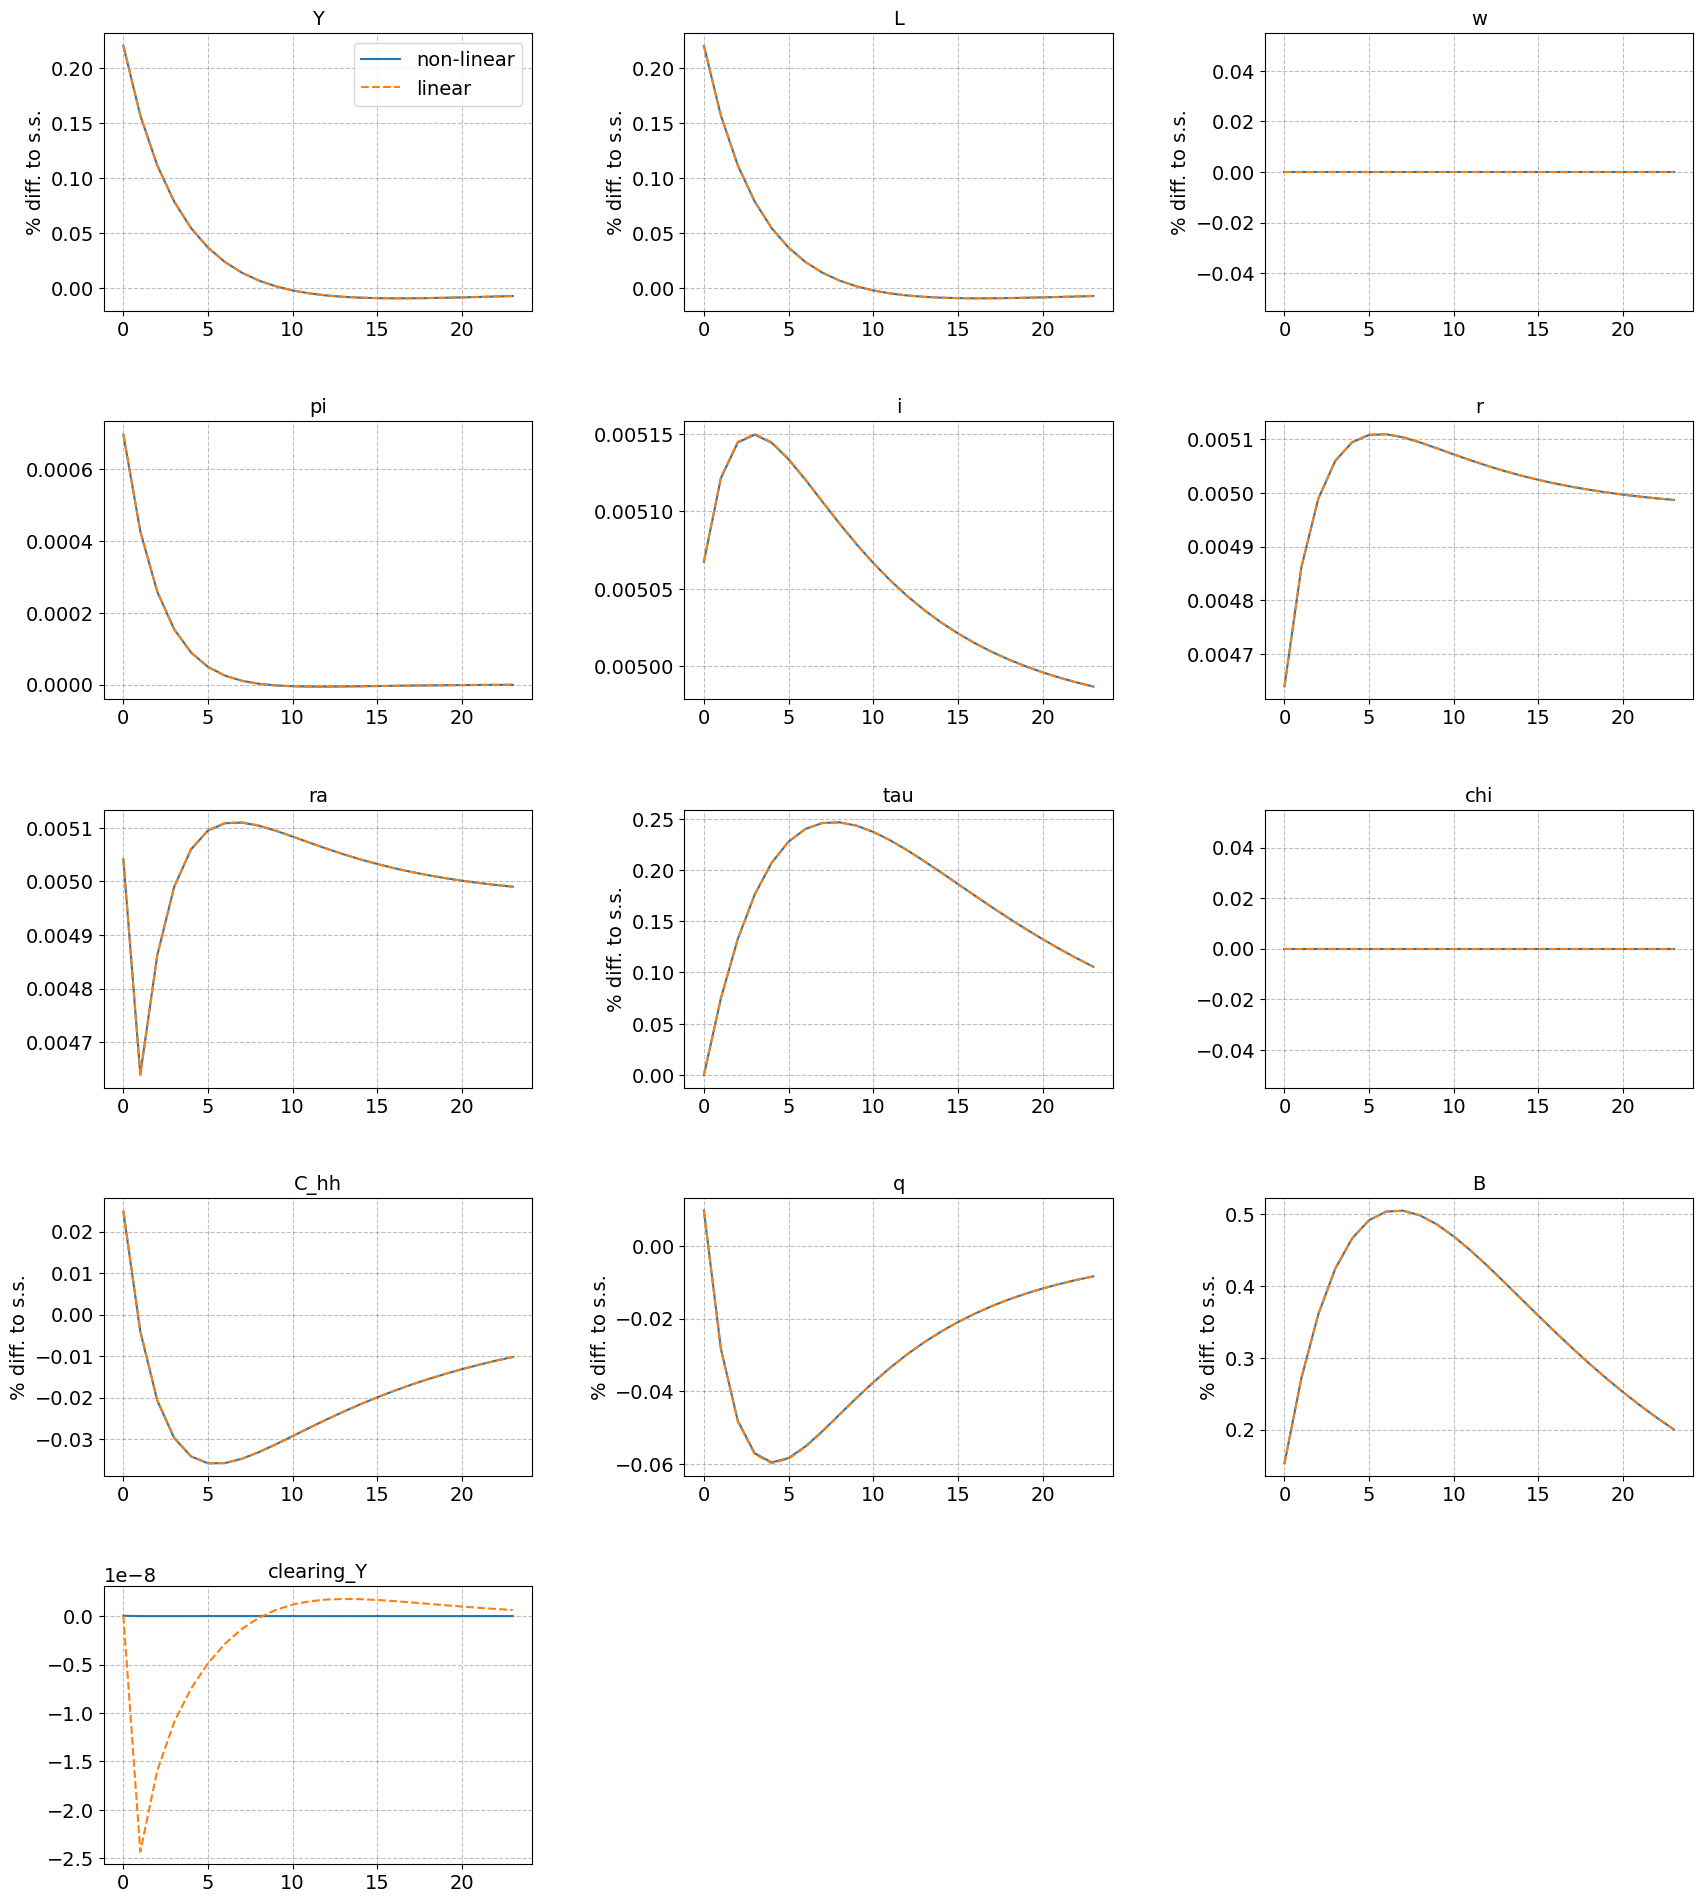


### tagets ###


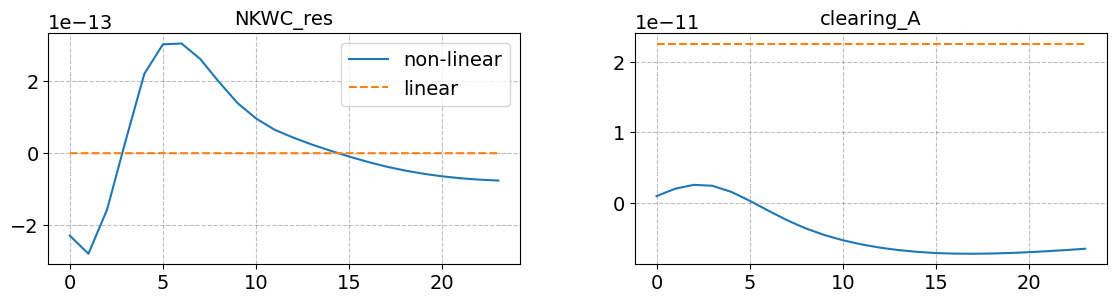

In [20]:
model.show_IRFs(paths,lvl_value=lvl_value,T_max=24,ncols=3,do_linear=True)

## 6. <a id='toc6_'></a>[Transfers](#toc0_)

In [21]:
model_chi = model.copy()

In [22]:
model_chi.par.jump_G = 0.0

In [23]:
# a. define shock
dchi = np.zeros(par.T)
dchi[:4] = 0.01*ss.G

shocks = {'dchi':dchi} # note the 'd' for difference (in absolute terms)

# b. find transition path
model_chi.compute_jacs()
model_chi.find_transition_path(shocks=shocks,do_print=True)

finding the transition path:
 it =   0 -> max. abs. error = 2.47e-03
   2.00e-04 in NKWC_res
   2.47e-03 in clearing_A
 it =   1 -> max. abs. error = 1.19e-05
   8.23e-07 in NKWC_res
   1.19e-05 in clearing_A
 it =   2 -> max. abs. error = 1.55e-08
   1.60e-09 in NKWC_res
   1.55e-08 in clearing_A
 it =   3 -> max. abs. error = 5.54e-12
   7.23e-13 in NKWC_res
   5.54e-12 in clearing_A

transition path found in 2.4 secs


### shocks ###


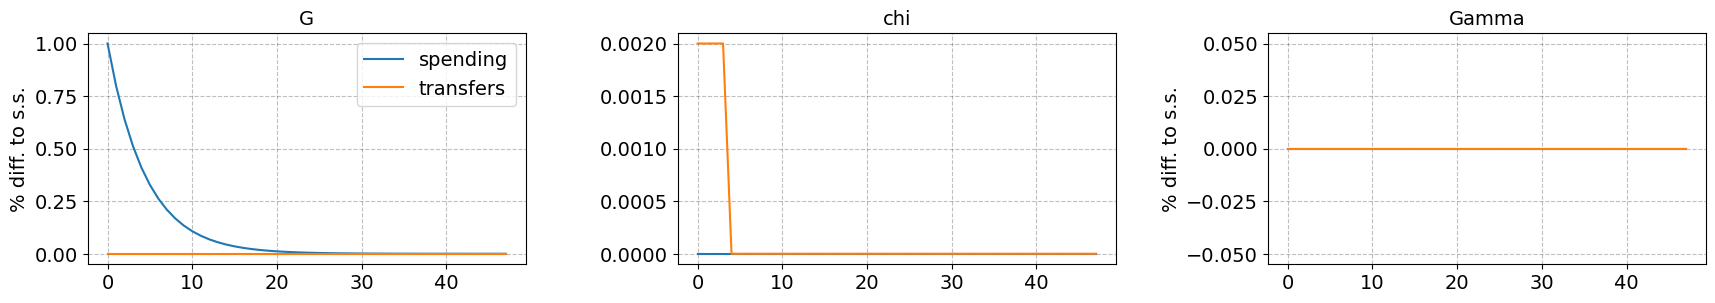


### varnames ###


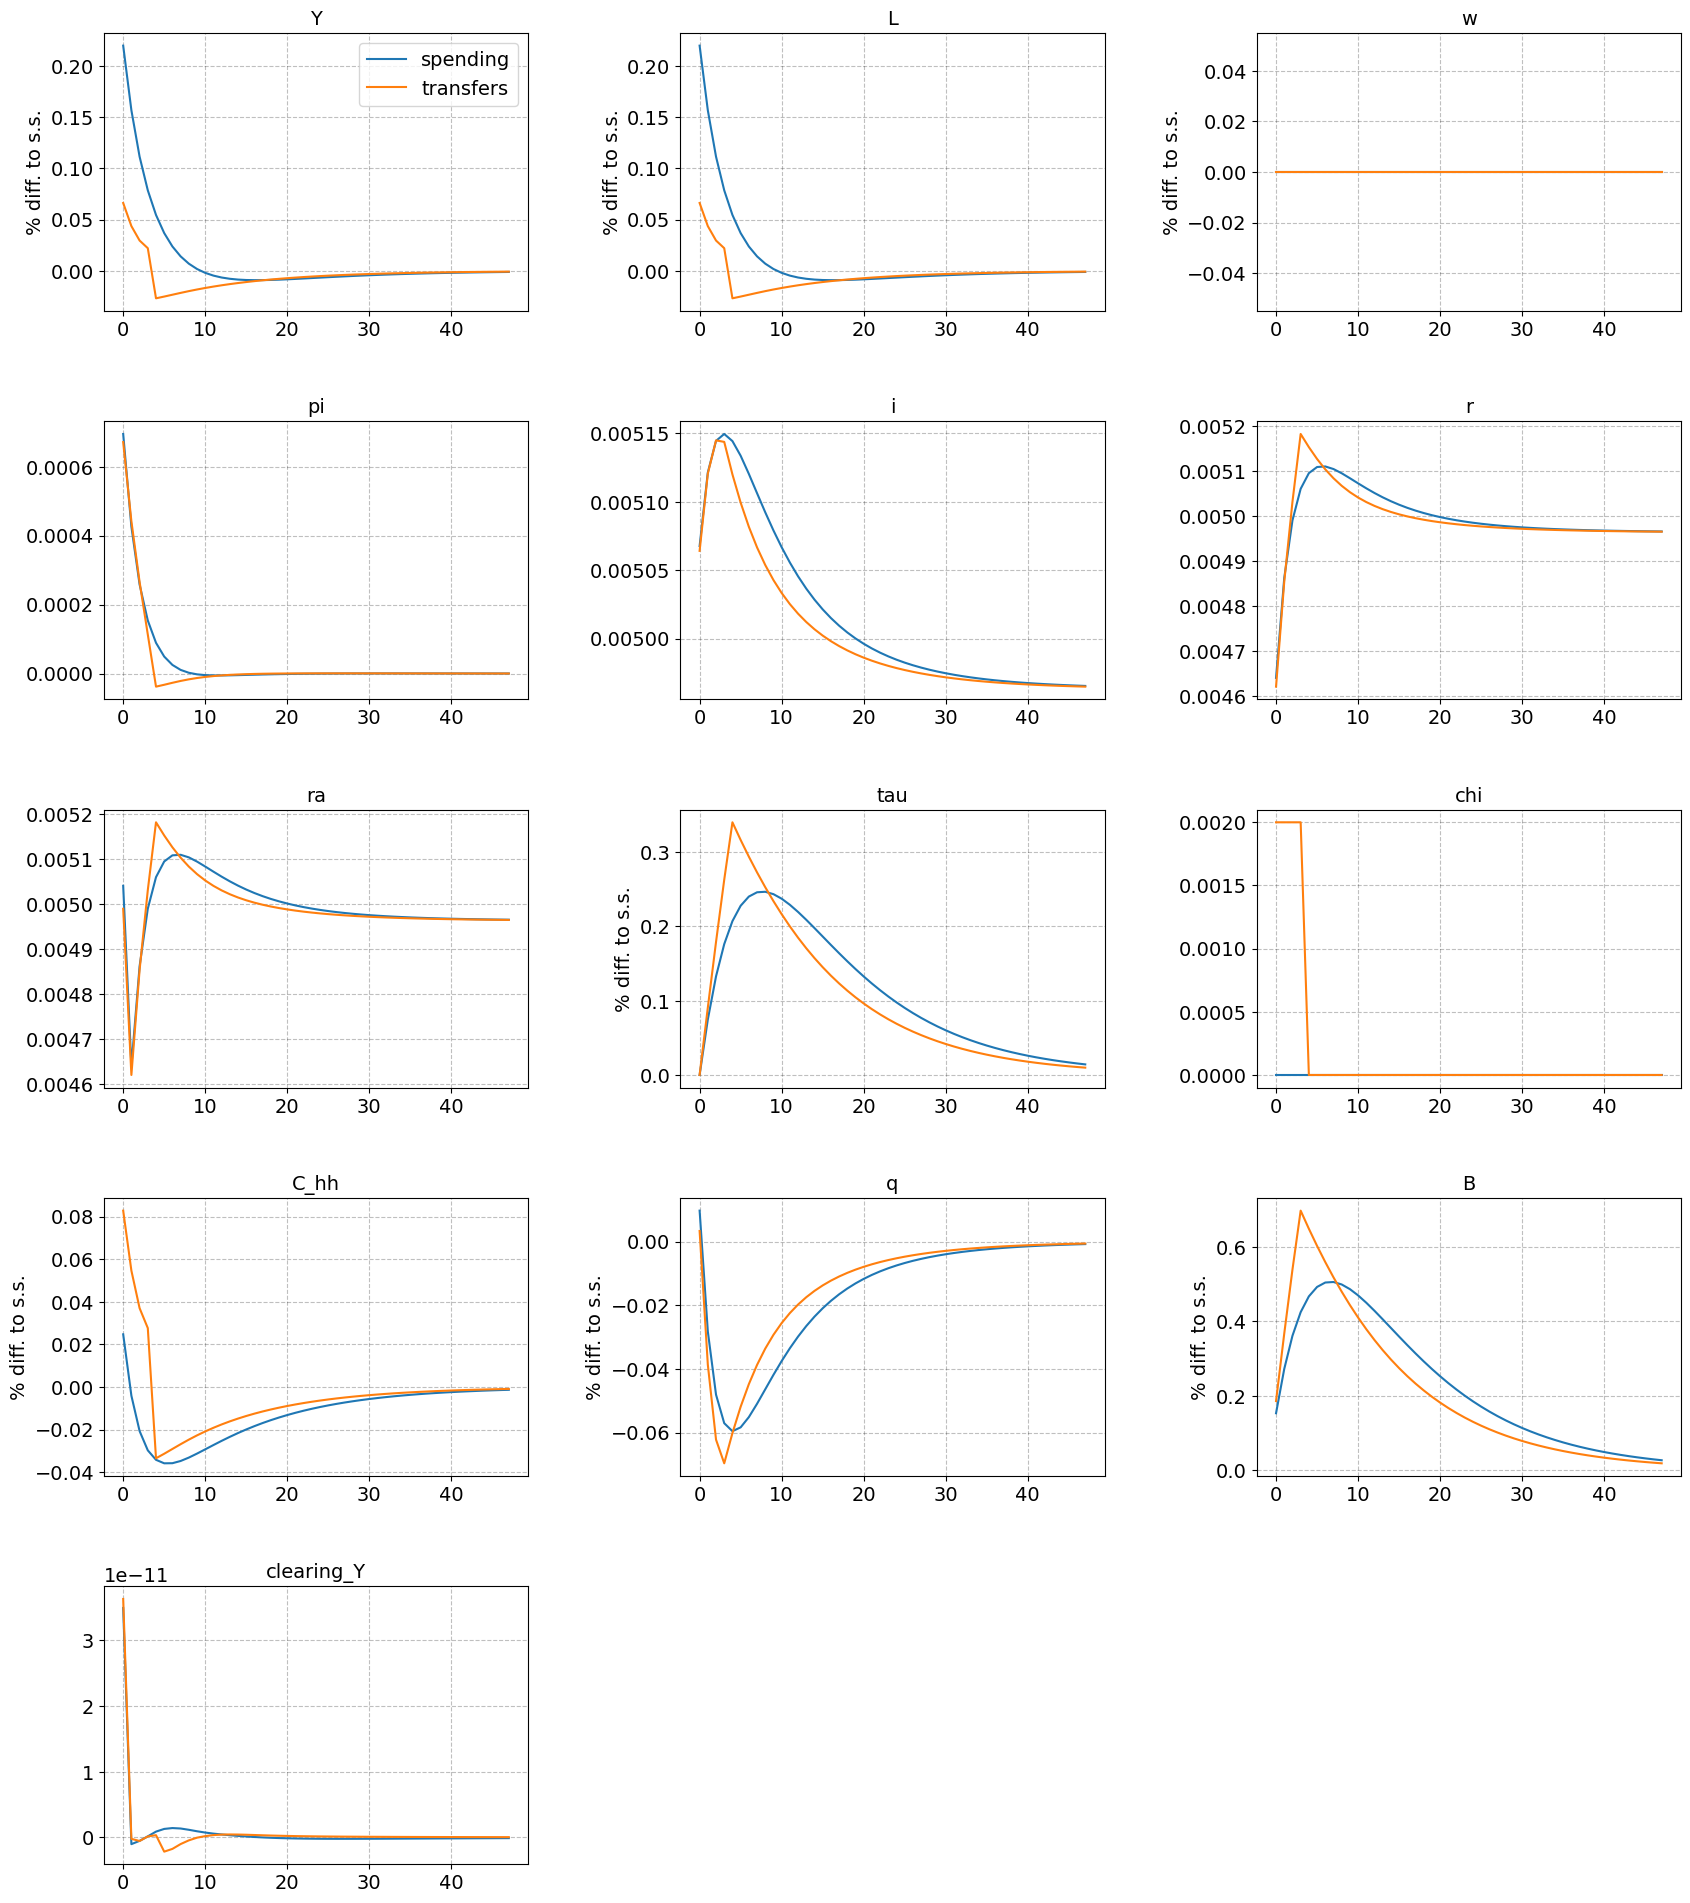


### tagets ###


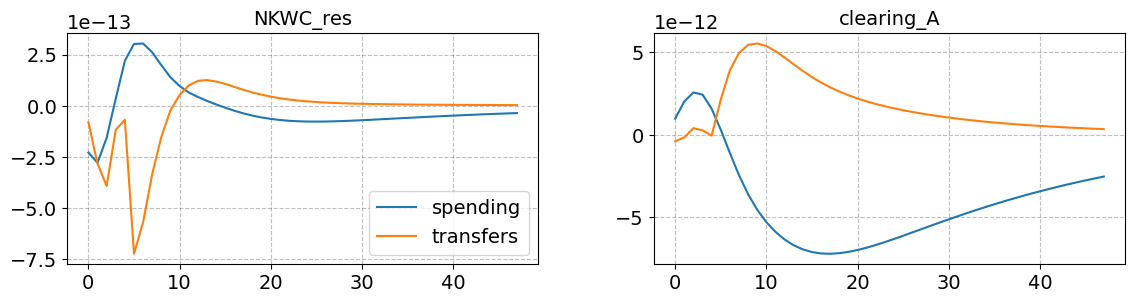

In [24]:
model.compare_IRFs(
    [model,model_chi],['spending','transfers'],
    paths,lvl_value=lvl_value,T_max=48,ncols=3)